Generate a movie of the projections and reconstructions from a selected sample

In [1]:
import os
import glob
import imageio
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import skimage.transform
from tqdm import tqdm_notebook
import time
from IPython import display

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...

In [4]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [6]:
BaseFolder = '/media/habi/Black Seagate/Zebra-Fish_Matthias/'
Sample = 'Control05'

In [7]:
BaseFolder = '/media/habi/Fast_SSD/Lung-Metastasis/'
Sample = 'KP-TNIKWT02'

In [8]:
# Get file names
Logfile = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'proj', '*.log')))[0]
Projections = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'proj', '*[0123456789]?.tif')))
Reconstructions = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'rec', '*.png')))

In [9]:
Pixelsize = get_pixelsize(Logfile)

In [10]:
# Details of the output movie
NumberOfFrames = 240
WidthOfOutput = 800
Seconds = 15

In [11]:
print('We have %s projections (%s - %s)' % (len(Projections),
                                            os.path.basename(Projections[0]),
                                            os.path.basename(Projections[-1])))
print('and %s reconstructions (%s - %s)' % (len(Reconstructions),
                                            os.path.basename(Reconstructions[0]),
                                            os.path.basename(Reconstructions[-1])))
print('of which %s images each which will be '
      'converted into a %s s long movie with a width of %s px' % (NumberOfFrames,
                                                                  Seconds,
                                                                  WidthOfOutput))

We have 940 projections (KP-TNIKWT200000000.tif - KP-TNIKWT200000939.tif)
and 506 reconstructions (KP-TNIKWT2_IR_rec00000204.png - KP-TNIKWT2_IR_rec00000709.png)
of which 240 images each which will be converted into a 15 s long movie with a width of 800 px


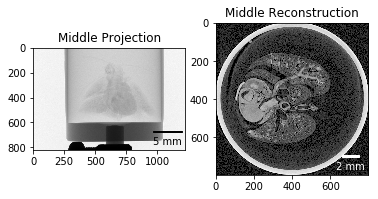

In [12]:
# Show middle images
plt.subplot(121)
plt.imshow(imageio.imread(Projections[len(Projections) // 2]))
plt.gca().add_artist(ScaleBar(Pixelsize, 'um', color='black'))
plt.title('Middle Projection')
plt.subplot(122)
plt.imshow(imageio.imread(Reconstructions[len(Reconstructions) // 2]))
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.title('Middle Reconstruction')
plt.show()

Write out a movie of rescaled projections and reconstructions

In [13]:
# Make output directories
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_proj'), exist_ok=True)
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_rec'), exist_ok=True)

In [14]:
OutputNameProj = os.path.join(BaseFolder, Sample, 'mov', '%s_%s_projections.mp4' % (Sample, NumberOfFrames))
OutputNameRec = os.path.join(BaseFolder, Sample, 'mov', '%s_%s_reconstructions.mp4' % (Sample, NumberOfFrames))

In [15]:
# based on https://stackoverflow.com/a/35943809/323100
with imageio.get_writer(OutputNameProj, fps=NumberOfFrames / Seconds) as writer:
    for filename in tqdm_notebook(Projections[::round(len(Projections) / NumberOfFrames)]):
        frame = imageio.imread(filename)
        frame_size = numpy.shape(frame)
        frame_resized = skimage.transform.rescale(frame, WidthOfOutput / frame_size[0])
        writer.append_data(skimage.img_as_ubyte(frame_resized))
print('Saved to %s' % OutputNameProj)


Saved to /media/habi/Fast_SSD/Lung-Metastasis/KP-TNIKWT02/mov/KP-TNIKWT02_240_projections.mp4


In [16]:
# Write out a movie of rescaled recoinstructions
# based on https://stackoverflow.com/a/35943809/323100
with imageio.get_writer(OutputNameRec, fps=NumberOfFrames / Seconds) as writer:
    for filename in tqdm_notebook(Reconstructions[::round(len(Projections) / NumberOfFrames)]):
        frame = imageio.imread(filename)
        frame_size = numpy.shape(frame)
        frame_resized = skimage.transform.rescale(frame,
                                                  WidthOfOutput / frame_size[0])
        writer.append_data(skimage.img_as_ubyte(frame_resized))
print('Saved to %s' % OutputNameRec)


Saved to /media/habi/Fast_SSD/Lung-Metastasis/KP-TNIKWT02/mov/KP-TNIKWT02_240_reconstructions.mp4


Write out single frames with a scale bar

In [17]:
# Delete files from previous runs, based on https://stackoverflow.com/a/37994379/323100
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_proj')):
    os.remove(file.path)
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_rec')):
    os.remove(file.path)

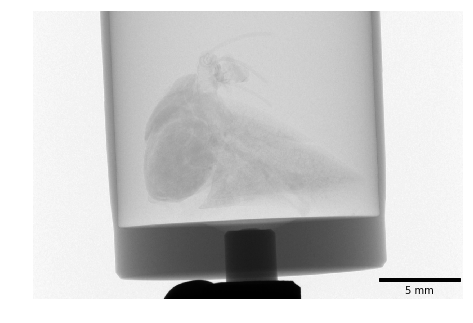

In [ ]:
# Full frame figure based on https://stackoverflow.com/a/8218887/323100
fig = plt.figure(frameon=False)
# Update same figure based on https://stackoverflow.com/a/29675706/323100
for c, filename in tqdm_notebook(enumerate(Projections[::round(len(Projections) / NumberOfFrames)]),
                                 total=len(Projections[::round(len(Projections) / NumberOfFrames)])):
    image = imageio.imread(filename)
    frame_size = numpy.shape(image)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(skimage.transform.rescale(imageio.imread(filename),
                                        WidthOfOutput / frame_size[0]),
              aspect='equal')
    ax.add_artist(ScaleBar(Pixelsize / (WidthOfOutput / frame_size[0]),
                           'um',
                           color='black'))
    fig.savefig(os.path.join(BaseFolder,
                             Sample,
                             'mov',
                             'mov_proj',
                             os.path.splitext(os.path.basename(filename))[0] + '.%03d.png' % c))
    display.display(plt.gcf())
    display.clear_output(wait=True)
print('Done')

In [ ]:
# Full frame figure based on https://stackoverflow.com/a/8218887/323100
fig = plt.figure(frameon=False)
# Update same figure based on https://stackoverflow.com/a/29675706/323100
for c, filename in tqdm_notebook(enumerate(Reconstructions[::round(len(Reconstructions) / NumberOfFrames)]),
                                 total=len(Reconstructions[::round(len(Reconstructions) / NumberOfFrames)])):
    image = imageio.imread(filename)
    frame_size = numpy.shape(image)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(skimage.transform.rescale(imageio.imread(filename),
                                        WidthOfOutput / frame_size[0]),
              aspect='equal')
    ax.add_artist(ScaleBar(Pixelsize / (WidthOfOutput / frame_size[0]),
                           'um', color='white'))
    fig.savefig(os.path.join(BaseFolder,
                              Sample,
                              'mov',
                              'mov_rec',
                              os.path.splitext(os.path.basename(filename))[0] + '.%03d.png' % c))
    display.display(plt.gcf())
    display.clear_output(wait=True)
print('Done')

Now convert the frames to a movie with this [`avconv` command](http://simp.ly/publish/3qqCM0)